# Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Loading Dataset

In [3]:
df = pd.read_csv('email_spam.csv',encoding='latin-1')

# Exploratory Data Analysis (EDA)

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df = df[['v1','v2']]
df.columns=['label','text']

In [6]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


#### We can see that there are no missing values but to ensure our understanding we can check it also

In [59]:
df.isnull().sum()

label           0
text            0
text_length     0
cleaned_text    0
spam            0
dtype: int64

#### To know how the data is distributed between the two classes (spam and ham). We will visualize this using a count plot.

c:\users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


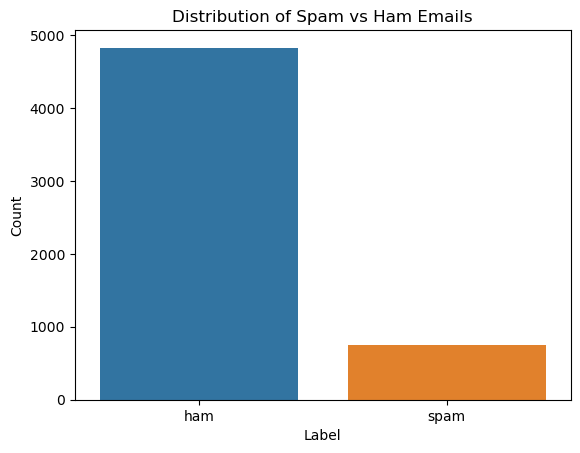

In [10]:
sns.countplot(df['label'])
plt.title('Distribution of Spam vs Ham Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [11]:
#Percentage distribution
spam_percentage = df['label'].value_counts(normalize=True) * 100
print(f"\nClass Distribution:\n{spam_percentage}")


Class Distribution:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


#### Text Length Analysis

In [12]:
# Adding a column for the length of the email/text
df['text_length']=df['text'].apply(len)

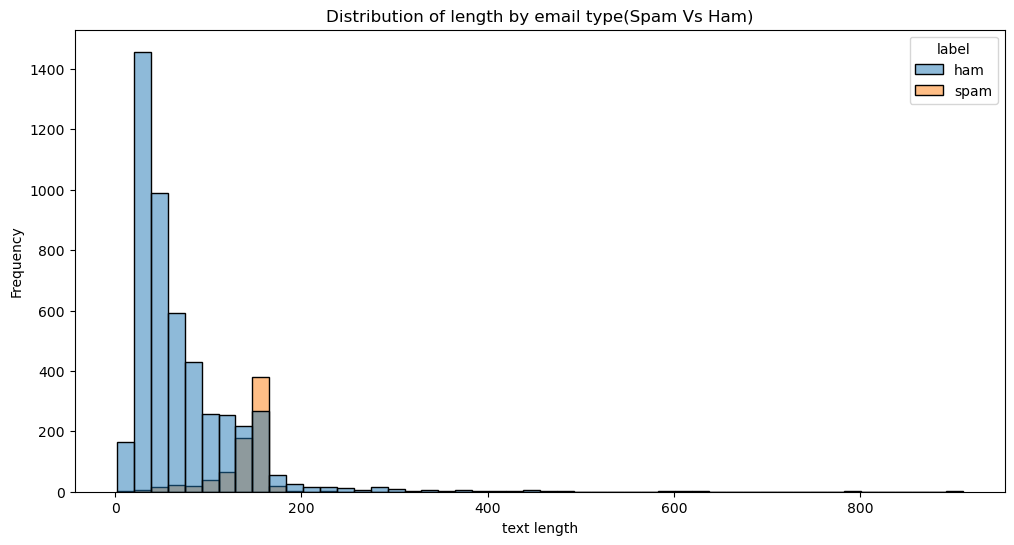

In [13]:
#plot the distribution of the length for ham/spam
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="text_length", hue="label", bins=50)
plt.title("Distribution of length by email type(Spam Vs Ham)")
plt.xlabel('text length')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Summary statistics for spam and ham text lengths
spam_text_length = df[df['label'] == 'spam']['text_length']
ham_text_length = df[df['label'] == 'ham']['text_length']

In [15]:
print(f"Average length of spam emails: {spam_text_length.mean():.2f}")
print(f"Average length of ham emails: {ham_text_length.mean():.2f}")

Average length of spam emails: 138.87
Average length of ham emails: 71.02


#### Word Frequency Analysis

In [62]:
# Import required libraries
from collections import Counter
import re
import string

In [63]:
# Function to clean the text (removing punctuation, converting to lowercase, etc.)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

In [64]:
# Apply the cleaning function to the text column
df['cleaned_text'] = df['text'].apply(clean_text)

In [65]:
# Tokenize the cleaned text and count word frequency
spam_words = ' '.join(df[df['label'] == 'spam']['cleaned_text']).split()
ham_words = ' '.join(df[df['label'] == 'ham']['cleaned_text']).split()

In [66]:
# Most common words in spam and ham emails
spam_word_freq = Counter(spam_words).most_common(20)
ham_word_freq = Counter(ham_words).most_common(20)

In [67]:
# Convert to DataFrame for visualization
spam_word_df = pd.DataFrame(spam_word_freq, columns=['Word', 'Frequency'])
ham_word_df = pd.DataFrame(ham_word_freq, columns=['Word', 'Frequency'])

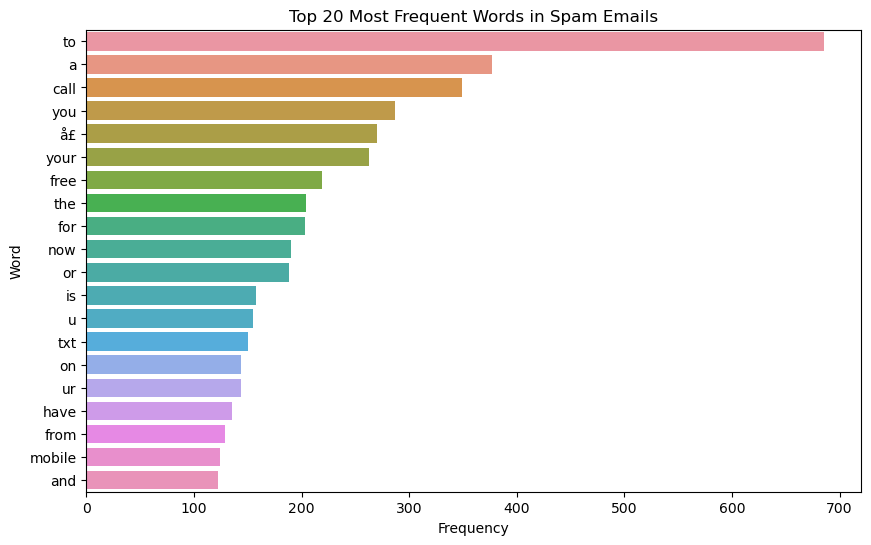

In [68]:
# Plot most frequent words in spam emails
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=spam_word_df)
plt.title('Top 20 Most Frequent Words in Spam Emails')
plt.show()

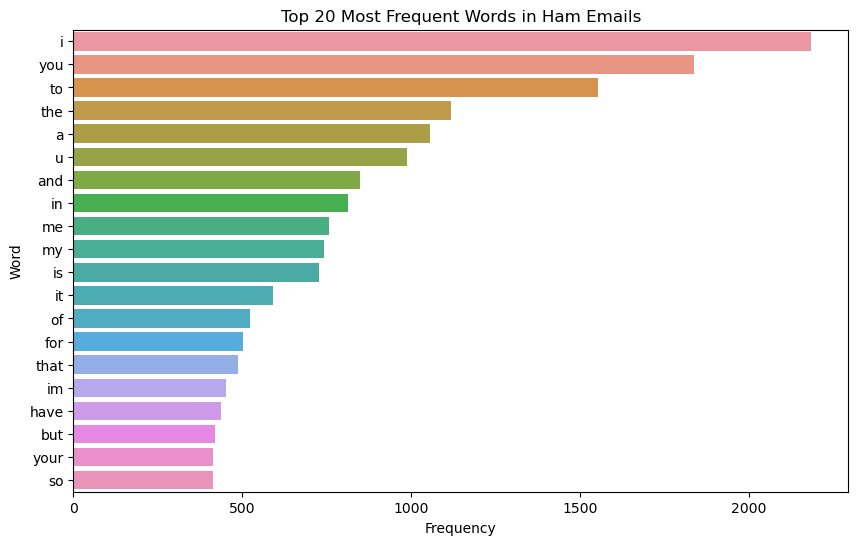

In [69]:
# Plot most frequent words in ham emails
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=ham_word_df)
plt.title('Top 20 Most Frequent Words in Ham Emails')
plt.show()

#### Correlation Between Text Length and Spam

In [19]:
# Correlation between text length and label
df['spam'] = df['label'].map({'ham': 0, 'spam': 1})

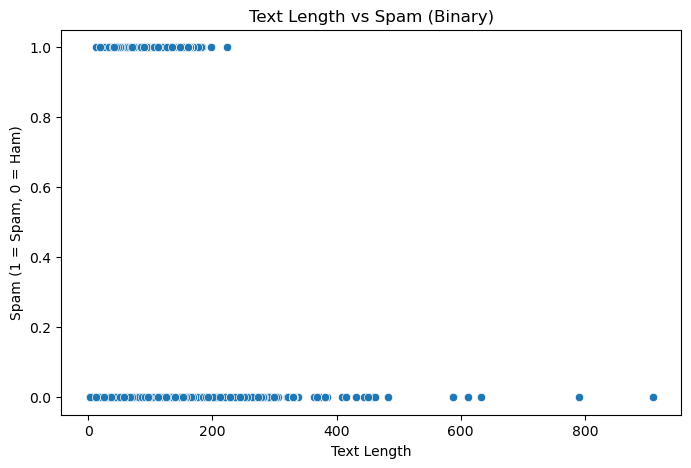

In [20]:
# Scatter plot of text length vs label
plt.figure(figsize=(8, 5))
sns.scatterplot(x='text_length', y='spam', data=df)
plt.title('Text Length vs Spam (Binary)')
plt.xlabel('Text Length')
plt.ylabel('Spam (1 = Spam, 0 = Ham)')
plt.show()

## Cleaning the email text

In [21]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove leading/trailing whitespace
    return text

##### Apply text cleaning to the dataset

In [22]:
df['text'] = df['text'].apply(clean_text)

Split the data into training and testing sets

In [23]:
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to numerical using TF-IDF Vectorizer

In [24]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf= vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize classifiers

In [25]:
log_reg = LogisticRegression(random_state=42)
nb = MultinomialNB()
svm = SVC(kernel='linear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

Why used this classifiers:-
1. Logistic Regression: A simple, fast linear model for binary classification.
2. Multinomial Naive Bayes: A probabilistic model that assumes feature independence and works well with word frequencies.
3. SVM (Linear Kernel): A powerful linear classifier that maximizes the margin between classes.
4. Random Forest: An ensemble method that builds multiple decision trees to improve accuracy and reduce overfitting.

## Training and evaluating Logistic Regression

In [26]:
log_reg.fit(X_train_tfidf, y_train)
y_pred_log = log_reg.predict(X_test_tfidf)
log_acc = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {log_acc}")
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9506726457399103
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       965
        spam       0.97      0.65      0.78       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115



Key Insights:
1. Imbalance in Class Recall:
The model is excellent at correctly identifying ham (non-spam) emails (100% recall), but it's missing 35% of the spam emails (recall of 0.65). This could be an issue if catching spam is crucial, as a significant number of spam emails are slipping through as ham.

2. High Precision for Spam:
The model is very confident when it labels an email as spam (precision of 0.97), meaning there are very few false positives (ham emails wrongly marked as spam). This is good if false positives (misclassifying ham as spam) are costly or undesirable.

3. Overall Accuracy is High, but Recall Matters:
While the accuracy (95%) looks good, it can be deceptive in imbalanced datasets. Here, since most emails are ham, the model’s strong performance on ham inflates the accuracy, but its recall on spam (65%) is lower, which could mean many spam emails aren't being caught.

## Training and evaluating Support Vector Machine (SVM)

In [60]:
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc}")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9820627802690582
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Key Insights:

1. Improved Recall for Spam:
Compared to logistic regression, SVM significantly improves the recall for spam, from 0.65 to 0.88. This means it catches 88% of spam emails, making it a more reliable model for detecting spam.

2. High Precision for Spam:
With a precision of 0.99 for spam, this model is very confident when labeling emails as spam. This means there are very few false positives (ham misclassified as spam), which is important in reducing frustration for users who might miss important emails.

3. High Overall Accuracy:
The SVM model has an overall accuracy of 98.21%, which is a significant improvement over the logistic regression model’s 95%. This indicates that the SVM model performs exceptionally well across both classes.

## Training and evaluating Naive Bayes

In [31]:
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
nb_acc = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_acc}")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.968609865470852
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115



Key Insights:

1. Perfect Precision for Spam:
The Naive Bayes classifier has perfect precision (1.00) for spam, meaning none of the emails predicted as spam were actually ham. This is crucial in applications where false positives (misclassifying ham as spam) are highly undesirable.

2. Lower Recall for Spam:
The recall for spam is 0.77, meaning 23% of actual spam emails were classified as ham. This is better than the logistic regression model (recall of 0.65 for spam) but lower than the SVM model (recall of 0.88). So while Naive Bayes is very cautious and accurate when it flags an email as spam, it misses more spam emails than SVM.

3. High Overall Performance for Ham:
For the ham class, Naive Bayes performs very well, with perfect recall (1.00) and strong precision (0.96). This means that all ham emails are correctly identified, and the misclassification of ham as spam is minimal.

## Training and evaluating Random Forest

In [32]:
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc}")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9713004484304932
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       1.00      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



Key Insights:

1. Perfect Precision for Spam:
The Random Forest model has perfect precision for spam (1.00), meaning it doesn’t misclassify any ham emails as spam. This makes it very cautious and accurate when identifying spam.

2. Moderate Recall for Spam:
The recall for spam is 0.79, meaning the model correctly identifies 79% of actual spam emails, while 21% are misclassified as ham. This recall is slightly better than Naive Bayes (0.77) but lower than SVM (0.88). So, while the model is good at avoiding false positives, it still misses some spam emails.

3. High Overall Performance for Ham:
For the ham class, the Random Forest model performs extremely well, with 100% recall and 97% precision, ensuring that almost all ham emails are correctly classified.

# Confusion Matrices for Each Model

In [46]:
cm_log = confusion_matrix(y_test, y_pred_log)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_rf = confusion_matrix(y_test, y_pred_rf)

In [47]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Plotting of confusion matrices for each model

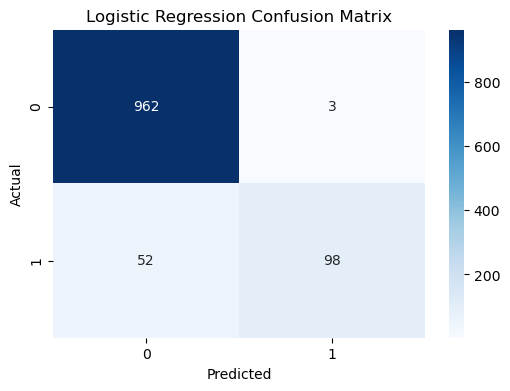

In [48]:
plot_confusion_matrix(cm_log, 'Logistic Regression Confusion Matrix')

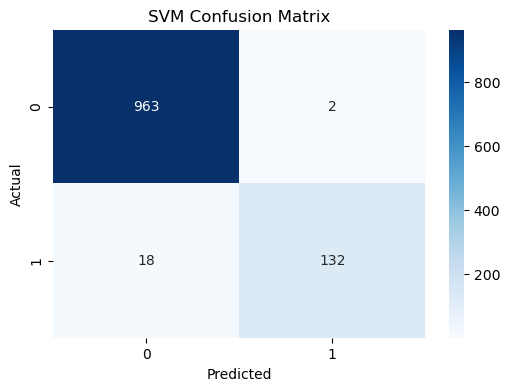

In [49]:
plot_confusion_matrix(cm_svm, 'SVM Confusion Matrix')

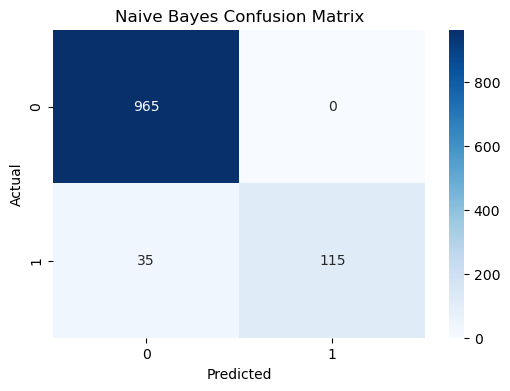

In [50]:
plot_confusion_matrix(cm_nb, 'Naive Bayes Confusion Matrix')

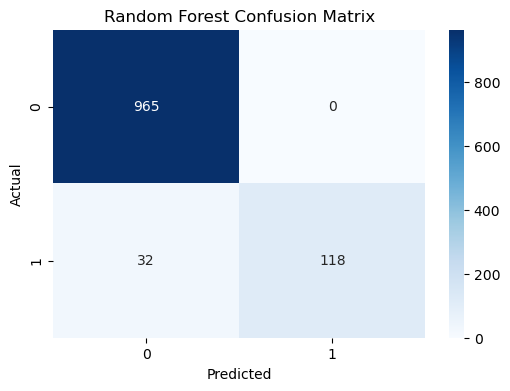

In [51]:
plot_confusion_matrix(cm_rf, 'Random Forest Confusion Matrix')

.

Key Takeaways from the Confusion Matrices:
- SVM is the best at correctly identifying spam emails (highest true positives and lowest false negatives).
- Logistic Regression struggles the most with spam detection (highest false negatives).
- All models are perfect at classifying ham emails, as no false positives (ham misclassified as spam) were recorded across the board.
- Naive Bayes and Random Forest perform similarly, with Random Forest having a slight edge in classifying spam.

# Comparing model accuracies

In [54]:
models = ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest']
accuracies = [log_acc, svm_acc, nb_acc, rf_acc]

In [55]:
accuracies

[0.9506726457399103, 0.9820627802690582, 0.968609865470852, 0.9713004484304932]

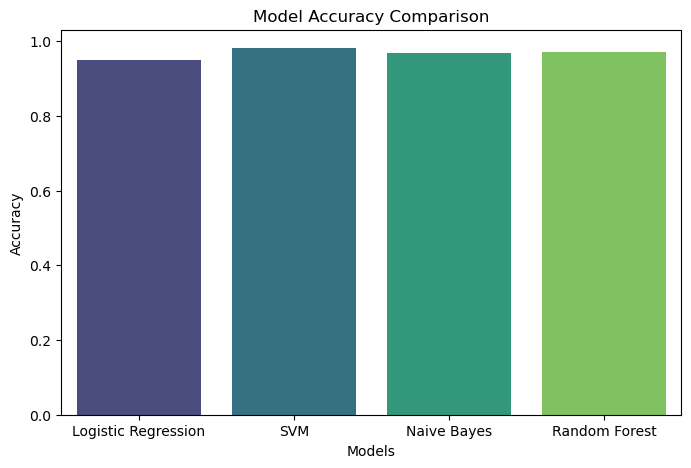

In [56]:
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.show()

# Hyperparameter Tuning

Hyperparameter tuning is a critical step in improving the performance of machine learning models by finding the best combination of parameters. For the Email Spam Detection project using classifiers like Random Forest or Support Vector Machine (SVM), we can optimize the hyperparameters using techniques like Grid Search or Random Search.

In [70]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [73]:
# Preprocess data (assuming df has 'label' and 'text' columns)
df['spam'] = df['label'].map({'ham': 0, 'spam': 1})
df['spam']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: spam, Length: 5572, dtype: int64

In [74]:
# Splitting into training and testing sets
X = df['text']  # Features (email text)
y = df['spam']  # Labels (spam/ham)

In [75]:
# Convert text data to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_tfidf = vectorizer.fit_transform(X)

In [76]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [77]:
# Label encode the target variable (0 for ham, 1 for spam)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Hyperparameter Tuning for Random Forest

For Random Forest, we can tune parameters such as:

- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of the tree.
- min_samples_split: Minimum number of samples required to split a node.
- min_samples_leaf: Minimum number of samples required to be at a leaf node.

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [80]:
# Set up the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [81]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [82]:
# Set up GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [83]:
# Fit the model
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=2)

In [84]:
# Best parameters and accuracy
print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest Accuracy:", grid_search_rf.best_score_)

Best Random Forest Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best Random Forest Accuracy: 0.9775619209894669


### Hyperparameter Tuning for Support Vector Classifier (SVC)

In [85]:
from sklearn.svm import SVC

In [86]:
# Set up the parameter grid for SVM
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf']
}

In [87]:
# Initialize the SVC model
svc_model = SVC(random_state=42)

In [88]:
# Set up GridSearchCV
grid_search_svc = GridSearchCV(estimator=svc_model, param_grid=param_grid_svc, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [89]:
# Fit the model
grid_search_svc.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy', verbose=2)

In [90]:
# Best parameters and accuracy
print("Best SVC Parameters:", grid_search_svc.best_params_)
print("Best SVC Accuracy:", grid_search_svc.best_score_)

Best SVC Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVC Accuracy: 0.9800309057375006


### Evaluating the Best Models

In [91]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [92]:
# Evaluate the best Random Forest model on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_accuracy}")
print(classification_report(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.979372197309417
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.85      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [93]:
# Evaluate the best SVC model on the test set
best_svc_model = grid_search_svc.best_estimator_
y_pred_svc = best_svc_model.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pred_svc)
print(f"SVC Test Accuracy: {svc_accuracy}")
print(classification_report(y_test, y_pred_svc))

SVC Test Accuracy: 0.9802690582959641
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



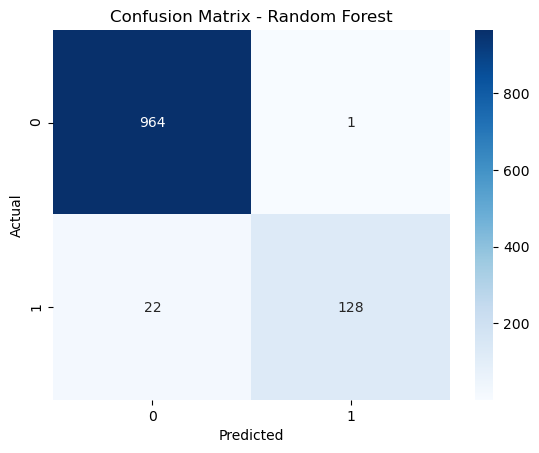

In [94]:
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

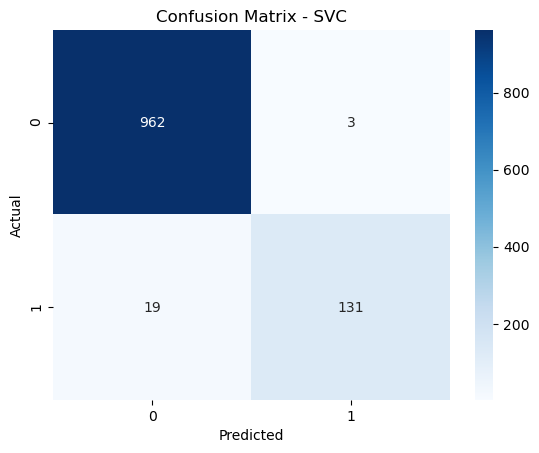

In [95]:
# Confusion matrix for SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Key Insights from the Comparison:

1. Overall Accuracy:
Both models have nearly identical accuracies around 98%, indicating both are highly capable of classifying emails as either spam or ham.

2. Class 0 (Ham):
Both models achieved perfect recall (1.00), meaning they didn’t miss any ham emails (no false positives). The precision for ham was also identical at 0.98.
This shows both models are equally effective at correctly classifying ham emails.

3. Class 1 (Spam):
Precision: Random Forest slightly outperformed SVC with a precision of 0.99 versus 0.98 for SVC. This means that when Random Forest predicted spam, it was correct slightly more often.
Recall: SVC had a slight advantage in spam recall, 0.87 compared to 0.85 for Random Forest. This means SVC was able to identify more actual spam emails, missing fewer of them.

4. F1-Score:
For spam emails, both models have the same F1-score of 0.92, indicating similar balance between precision and recall.Macro Avg F1-Score: SVC has a slight edge here with 0.96, compared to 0.95 for Random Forest. This takes into account the F1-scores for both ham and spam, and the slight improvement comes from the better recall of spam in the SVC model.

5. Weighted Avg F1-Score:
Both models have a weighted F1-score of 0.98, indicating very high performance across all classes, weighted by the number of samples.
### Which Model to Choose?

- Random Forest:
Slightly better precision for spam, meaning it is less likely to produce false positives (labeling a ham email as spam).
More interpretable due to its structure as a collection of decision trees, and easier to tune with additional hyperparameters (e.g., adjusting feature importance).

- SVC:
Slightly better recall for spam: It detects more spam emails but may let through a small number of false positives (ham emails labeled as spam).
More robust in cases with high-dimensional data and might generalize slightly better to unseen data.

### Final Recommendation:

If you value precision more (i.e., avoiding false positives, where ham emails are classified as spam), then Random Forest is the better choice.

If you value recall more (i.e., ensuring you catch as many spam emails as possible, even if it means a few more false positives), then SVC would be a better choice.

In [96]:
import pickle

with open('spam_classifier_model.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)
